In [63]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from geopy.distance import geodesic
from haversine import haversine, Unit

In [64]:
bike_data = pd.read_csv('data/202301-bluebikes-tripdata.csv')

In [65]:
bike_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,250,2023-01-01 00:02:54.0800,2023-01-01 00:07:04.4100,36,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,21,Prudential Center - 101 Huntington Ave,42.346520,-71.080658,4213,Subscriber,02115
1,489,2023-01-01 00:10:33.3100,2023-01-01 00:18:42.3690,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,-71.083370,3153,Customer,NaN
2,461,2023-01-01 00:10:49.9130,2023-01-01 00:18:31.1280,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,-71.083370,3431,Customer,02186
3,1065,2023-01-01 00:13:58.0640,2023-01-01 00:31:43.5090,58,Mugar Way at Beacon St,42.355536,-71.072869,345,Park Plaza at Charles St S.,42.351828,-71.067811,4398,Customer,NaN
4,601,2023-01-01 00:14:02.6130,2023-01-01 00:24:03.8950,50,Boylston St at Berkeley St,42.351142,-71.073292,374,Tremont St at Hamilton Pl,42.356683,-71.061666,7964,Subscriber,02138


In [66]:
bike_data.shape

(140340, 14)

In [67]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140340 entries, 0 to 140339
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tripduration             140340 non-null  int64  
 1   starttime                140340 non-null  object 
 2   stoptime                 140340 non-null  object 
 3   start station id         140340 non-null  int64  
 4   start station name       140340 non-null  object 
 5   start station latitude   140340 non-null  float64
 6   start station longitude  140340 non-null  float64
 7   end station id           140340 non-null  int64  
 8   end station name         140340 non-null  object 
 9   end station latitude     140340 non-null  float64
 10  end station longitude    140340 non-null  float64
 11  bikeid                   140340 non-null  int64  
 12  usertype                 140340 non-null  object 
 13  postal code              131990 non-null  object 
dtypes: f

In [68]:
bike_data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid
count,1.403400e+05,140340.000000,140340.000000,140340.000000,140340.00000,140340.000000,140340.000000,140340.000000
mean,1.260807e+03,206.073571,42.359247,-71.091262,204.45600,42.359176,-71.090774,5785.957076
std,1.935545e+04,174.294858,0.018060,0.026352,174.21936,0.017997,0.026327,2001.094702
min,6.100000e+01,3.000000,42.255600,-71.247759,1.00000,42.255600,-71.247759,2007.000000
25%,3.860000e+02,67.000000,42.348545,-71.107287,67.00000,42.348706,-71.106500,4063.000000
50%,6.170000e+02,142.000000,42.359825,-71.093198,139.00000,42.359573,-71.091567,5964.000000
75%,1.001000e+03,365.000000,42.368952,-71.073292,364.00000,42.368605,-71.072869,7704.000000
max,2.296250e+06,591.000000,42.529900,-70.886930,591.00000,42.529900,-70.886930,8708.000000


# Feature Engineering

In [69]:
# Check for NaN values in latitude and longitude columns
print(bike_data[['start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']].isnull().sum())


start station latitude     0
start station longitude    0
end station latitude       0
end station longitude      0
dtype: int64


## Create duration types (short, average, long, extra long)

In [70]:
bike_data['tripduration'] = np.where(bike_data['tripduration'] < 3600, "short_trip", np.where(
    (bike_data['tripduration'] > 3600) & (bike_data['tripduration'] < 3600 * 24), "average_trip", np.where(
    (bike_data['tripduration'] > 3600 * 24) & (bike_data['tripduration'] < 3600 * 24 * 30), "long_trip",
        "extra_long_trip")))

## Calculate Distance (in kilometers) 

In [71]:
def calculate_distances_vectorized(df):
    start_coords = list(zip(df['start station latitude'], df['start station longitude']))
    end_coords = list(zip(df['end station latitude'], df['end station longitude']))
    return np.array([haversine(start, end, unit=Unit.KILOMETERS) for start, end in zip(start_coords, end_coords)])


In [72]:
bike_data['distance'] = calculate_distances_vectorized(bike_data)

## Encode the 'member_casual', 'rideable_type', 'duration' column

In [73]:
label_encoder = LabelEncoder()
bike_data['user_type_encoded'] = label_encoder.fit_transform(bike_data['usertype'])
# bike_data['rideable_type_encoded'] = label_encoder.fit_transform(bike_data['rideable_type'])
bike_data['duration_type_encoded'] = label_encoder.fit_transform(bike_data['tripduration'])

## Select relevant features

In [74]:
# Select relevant features for anomaly detection
# features = ['duration', 'distance', 'member_casual_encoded']
# features = ['duration_type_encoded', 'distance', 'member_casual_encoded', 'rideable_type_encoded']
features = ['duration_type_encoded', 'distance', 'user_type_encoded']
features = ['duration_type_encoded']
X = bike_data[features]


# Data Analysis

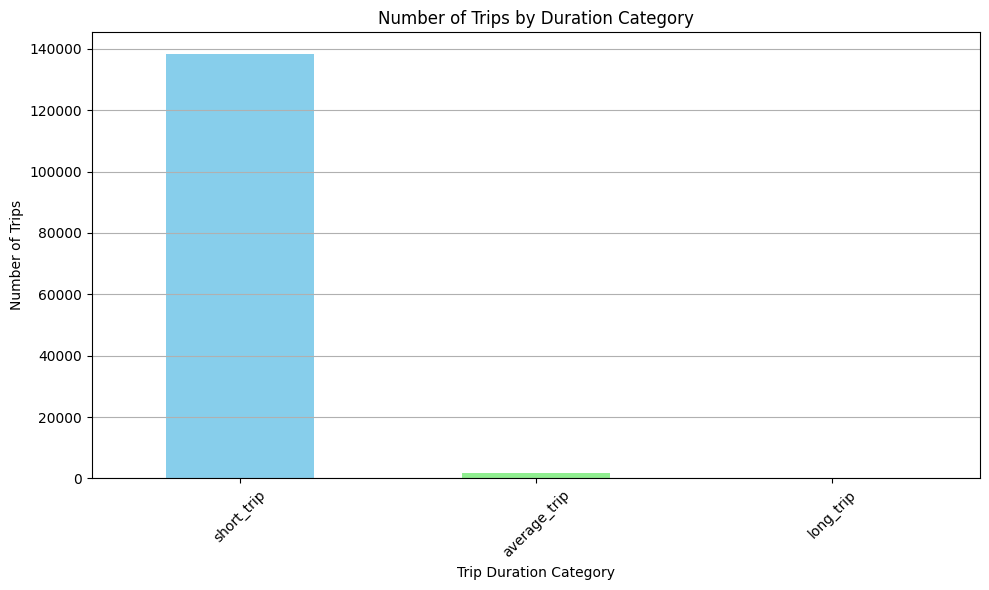

In [75]:
# Count the number of trips in each category
trip_counts = bike_data['tripduration'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.title('Number of Trips by Duration Category')
plt.xlabel('Trip Duration Category')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [76]:
trip_counts

tripduration
short_trip      138477
average_trip      1735
long_trip          128
Name: count, dtype: int64

In [77]:
contamination = trip_counts['long_trip'] / bike_data.shape[0]

In [78]:
contamination

np.float64(0.0009120706854781245)

# Train Isolation Forest

In [79]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=contamination, n_estimators=100, max_samples=0.6, max_features=0.9) 

# Fit the model to the data
bike_data['anomaly'] = iso_forest.fit_predict(X)


# Plot the Anomalies

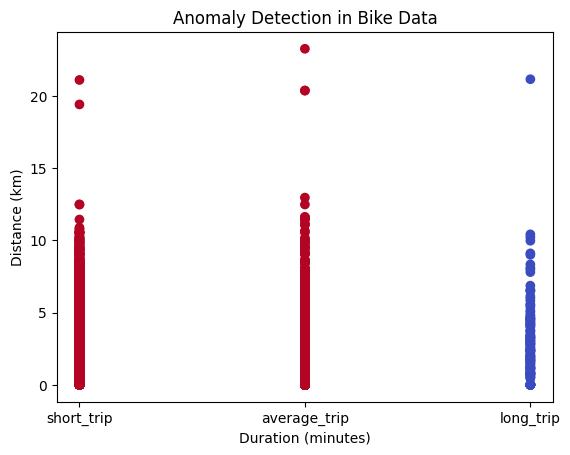

     tripduration                 starttime                  stoptime  \
332     long_trip  2023-01-01 02:51:52.3060  2023-01-02 11:32:45.8290   
512     long_trip  2023-01-01 08:26:59.3910  2023-01-04 10:35:25.7010   
580     long_trip  2023-01-01 09:24:20.9730  2023-01-04 11:34:40.7390   
788     long_trip  2023-01-01 10:57:25.7460  2023-01-02 12:28:50.1950   
1629    long_trip  2023-01-01 14:05:59.3760  2023-01-06 20:23:18.3270   

      start station id                                 start station name  \
332                 55                   Boylston St at Massachusetts Ave   
512                138  Newmarket Square T Stop - Massachusetts Ave at...   
580                218  Watermark Seaport - Boston Wharf Rd at Seaport...   
788                 68              Central Square at Mass Ave / Essex St   
1629               387                                        7 Acre Park   

      start station latitude  start station longitude  end station id  \
332                42.347

In [80]:
# Visualize the anomalies (1 = normal, -1 = anomaly)
plt.scatter(bike_data['tripduration'], bike_data['distance'], c=bike_data['anomaly'], cmap='coolwarm')
plt.xlabel('Duration (minutes)')
plt.ylabel('Distance (km)')
plt.title('Anomaly Detection in Bike Data')
plt.show()

# Print detected anomalies
anomalies = bike_data[bike_data['anomaly'] == -1]
print(anomalies.head())

In [81]:
anomalies.shape

(128, 18)